<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Modelos de Inferência Causal. </i>       
</p>  

# <font color='orange' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid orange;'>

In [1]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import bernoulli, binom, poisson, geom, norm, chi2, f, chi2_contingency, normaltest, ttest_ind, ttest_rel, wilcoxon, mannwhitneyu, kruskal
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 
import plotly.graph_objects as go
import plotnine as p

# Bibliotecas de Modelagem
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causalinference import CausalModel
import econml
import dowhy
from dowhy import CausalModel
from econml.dml import LinearDML
from econml.grf import CausalForest # Implementa o Causal Forest “puro”, no estilo do paper original de Athey, Tibshirani & Wager (2019). Esse método é diretamente baseado no framework de florestas generalizadas (GRF), onde a floresta é ajustada para estimar funções condicionais como: o efeito causal condicional (CATE)
from econml.dml import CausalForestDML # Implementa o Causal Forest dentro do arcabouço Double Machine Learning (DML). 

# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='orange' style='font-size: 40px;'> Estrutura de um Experimento </font>
<hr style='border: 2px solid orange;'>

### 1) ATE, ATT e CATE

> 1. O primeiro passo para se tornar sólido em inferência causal é compreender profundamente o conceito de efeito causal médio (ATE — Average Treatment Effect) e efeito causal condicional (CATE — Conditional Average Treatment Effect):

- O Efeito Médio do Tratamento (ATE — Average Treatment Effect) representa o impacto médio de uma intervenção sobre toda a população. Ele busca responder à pergunta: “qual seria o efeito médio do tratamento se ele fosse aplicado a todos os indivíduos, tratados e não tratados?”. Ele representa a diferença média esperada na renda estimada dos clientes caso todos usassem o novo modelo, em comparação com o cenário em que ninguém o utilizasse. Em outras palavras, o ATE responde à pergunta: “em média, qual seria a mudança na renda prevista se todo o portfólio de clientes fosse avaliado pelo novo modelo?”. Essa medida é útil quando o objetivo é entender o efeito global da intervenção sobre toda a população, sem distinguir grupos ou perfis específicos.

#### $$ ATE = E[Y_{tratado} - Y_{controle}] $$

- O Efeito Médio do Tratamento sobre os Tratados (ATT — Average Treatment Effect on the Treated), por sua vez, restringe o foco para os indivíduos que realmente receberam o tratamento. Ele responde à pergunta: “qual foi o efeito médio do tratamento entre aqueles que de fato foram expostos à intervenção?”. Ele busca responder: “entre os clientes que realmente usaram o novo modelo, quanto a renda prevista mudou em média por causa dele?”. Essa medida é importante porque, na prática, nem sempre o tratamento é aplicado a todos os indivíduos — muitas vezes, o banco testa o novo modelo apenas em um grupo-piloto antes de expandi-lo. Assim, o ATT mostra o impacto real que o novo modelo produziu no grupo tratado, sem supor que o mesmo efeito valeria para toda a base.

#### $$ ATT = E[Y_{tratado} - Y_{controle} | T = 1] $$

- Já o Efeito Médio Condicional (CATE — Conditional Average Treatment Effect) introduz um nível adicional de granularidade ao reconhecer que o efeito do tratamento pode variar de acordo com as características individuais dos participantes. Ele busca responder: “qual é o efeito médio do tratamento para indivíduos com determinadas características X?”. Ele responde à pergunta: “qual é o impacto médio do novo modelo de rendas para clientes com certas características, como renda baixa, renda média ou renda alta?”. O CATE reconhece que o efeito do tratamento não é o mesmo para todos — por exemplo, o novo modelo pode melhorar significativamente as previsões de renda em clientes de baixa renda (porque o modelo antigo os subestimava), mas ter pouco efeito em clientes de alta renda (onde o modelo antigo já era mais preciso). Em resumo, o CATE ajuda a entender para quem o modelo funciona melhor ou pior, permitindo decisões mais direcionadas e justas.

#### $$ CATE_{x} = E[Y_{tratado} - Y_{controle} | X = x] $$

> 2. A base teórica para esses conceitos está no Modelo de Resultados Potenciais de Rubin, que define que cada indivíduo tem dois resultados possíveis: um caso receba o tratamento (Y(1)) e outro caso não receba (Y(0)). O desafio é que nunca observamos os dois ao mesmo tempo, o que gera o chamado problema fundamental da inferência causal. Todo o arcabouço metodológico posterior — PSM, DiD, Causal Forest — é uma forma de estimar esse contrafactual ausente.

> 3. Exemplo: em um banco que implementou um novo modelo de crédito, o ATE responderia à pergunta “em média, o novo modelo reduziu o default rate da carteira?”, enquanto o CATE permitiria uma visão granular: “entre clientes de baixa renda, o novo modelo reduziu o default em 6 p.p., enquanto entre clientes de alta renda, a redução foi de apenas 2 p.p.”. Assim, o CATE revela para quem o efeito é mais forte — algo essencial em decisões de risco, marketing e política de crédito.

### 2) Experimentos Randomizados Controlados (Testes A/B)

> 1. Depois de dominar o conceito de efeito causal, o segundo passo é entender o cenário ideal: o experimento randomizado controlado, também conhecido como Teste A/B. Nele, a designação de tratamento (ex.: exposição a um novo modelo de crédito ou política de corte) é feita de forma aleatória, garantindo por construção que o grupo tratado e o grupo controle sejam comparáveis. Isso torna possível estimar o ATE de forma direta, simplesmente pela diferença entre as médias dos grupos:

#### $$ ATE = E[Y|T=1] - E[Y|T=0] $$

> 2. A análise estatística em Testes A/B envolve conceitos familiares, como intervalos de confiança, teste t, análise de poder estatístico e controle de false positives. Essa etapa é essencial porque define o padrão-ouro da inferência causal: randomizar é a forma mais limpa de estimar causalidade. Para o contexto bancário, isso é aplicável em pilotos controlados de novos modelos de crédito, ajustes de limites, políticas de cobrança ou ofertas de renegociação. Mesmo quando a randomização completa não é possível, compreender Testes A/B ajuda a avaliar o quão distante seu cenário observacional está desse ideal.

> 3. Exemplo: um banco pode aplicar um Teste A/B ao lançar um novo modelo de crédito: metade dos clientes recebe o modelo novo, metade continua com o antigo. Se o grupo tratado apresentar 3 p.p. menor taxa de default em média, isso fornece uma estimativa direta do ATE do modelo.

### 3) Propensity Score Matching e Inverse Probability Weighting

> 1. Em muitos casos, especialmente em bancos, a randomização perfeita é impossível, e o grupo Piloto acaba sendo composto por uma amostra enviesada — por exemplo, regiões com menor inadimplência ou carteiras de clientes com melhor histórico. Nesse caso, o terceiro passo é entender os métodos de ajuste observacional, sendo o Propensity Score Matching (PSM) o mais clássico. Ele consiste em estimar a probabilidade de um cliente receber o tratamento com base em suas covariáveis e, em seguida, parear clientes tratados e não tratados com propensões similares. Assim, tentamos criar um grupo controle “equivalente” ao grupo tratado, reduzindo o viés de seleção.

> 2. No entanto, o pareamento pode desperdiçar muitas observações, e por isso métodos como o Inverse Probability Weighting (IPW) — que repondera os indivíduos com base $1/P_{PSM}$ a fim de rebalancear a amostra. É muito usado para eliminar viés de seleção em Targets de Modelos

> 3. Exemplo: 

- PSM: Suponha que o banco só ofereceu um novo modelo de crédito em regiões de menor risco. O PSM permite simular um cenário comparável ao “contrafactual”, ajustando o peso dos clientes de alto risco que não receberam o novo modelo para equilibrar o grupo.

- IPW: Suponha que deseja-se criar um modelo de rendas mas só há target para o público de renda observada. O IPW permite usar o PSM e, baseado na probabilidade, criar uma amostra ponderada para eliminar viés de seleção.

### 4) Difference-in-Difference

> 1. Após dominar os métodos de pareamento, o quarto passo é estudar o Difference-in-Differences (DiD), uma técnica quase-experimental essencial quando há dados antes e depois da intervenção tanto para o grupo tratado quanto para o grupo controle. A ideia do DiD é que, se as tendências dos grupos eram paralelas antes do tratamento, qualquer diferença adicional observada após o tratamento pode ser atribuída ao efeito causal. Formalmente, o estimador é dado por:

#### $$ DiD = (Y1_{tratado} - Y0_{tratado}) - (Y1_{controle} - Y0_{controle}) $$

> 2. O DiD é extremamente poderoso porque elimina vieses fixos no tempo e permite medir mudanças relativas. É ideal para avaliar o impacto de novos modelos, políticas de aprovação, campanhas ou regras de score implementadas apenas em parte da carteira ou em regiões específicas. Um ponto crítico é sempre verificar a suposição de tendências paralelas por meio de análises gráficas ou testes placebo — isso garante a validade causal da inferência.

> 3. Exemplo: suponha que um banco introduziu um novo modelo de crédito apenas em São Paulo em janeiro, e deseja avaliar seu impacto comparando com o Rio de Janeiro, que manteve o modelo antigo. Se antes da mudança os defaults evoluíam de forma similar nas duas regiões, mas depois o default caiu mais em São Paulo, o DiD capta esse efeito diferencial.

### 5) Causal Forest

> 1. O quinto passo é compreender os métodos de Causal Machine Learning, em especial o Causal Forest e o Generalized Random Forest (GRF). Essas técnicas combinam a lógica da inferência causal com o poder preditivo do aprendizado de máquina. Enquanto as florestas tradicionais buscam minimizar o erro de previsão, o Causal Forest é projetado para identificar heterogeneidades no efeito causal, ou seja, estimar o CATE(x) — o efeito esperado do tratamento para indivíduos com características específicas. Cada árvore no Causal Forest é construída para maximizar a diferença esperada de efeitos entre subgrupos homogêneos, e a média das árvores fornece uma estimativa robusta e interpretável. No contexto bancário, isso significa descobrir “para quem” o novo modelo de crédito funciona melhor: talvez ele reduza o default rate fortemente entre autônomos, mas tenha efeito neutro em servidores públicos.

> 2. Em outras palavras, enquanto uma floresta comum responde “qual o default esperado dado a renda e a idade?”, a Causal Forest responde “qual a diferença esperada no default se esse cliente for avaliado com o novo modelo de crédito em vez do antigo?”.

> 3. Exemplo: em um banco, o Causal Forest pode mostrar que o novo modelo de crédito reduziu o default rate em 8 p.p. entre autônomos, mas teve efeito neutro em servidores públicos. Essa descoberta ajuda a direcionar políticas segmentadas — como ajustar limites, revisar regras de concessão ou oferecer produtos diferenciados — de modo orientado por evidência causal e não apenas correlação. 

# <font color='orange' style='font-size: 40px;'> Exemplo Propensity Score Matching </font>
<hr style='border: 2px solid orange;'>

> O Propensity Score Matching é uma técnica de inferência causal que busca aproximar um experimento aleatório a partir de dados observacionais. A ideia central é estimar a probabilidade de um indivíduo receber o tratamento com base em suas características observáveis (o propensity score) e, em seguida, parear indivíduos tratados e não tratados com escores semelhantes. Isso reduz o viés de seleção proveniente de diferenças observáveis entre os grupos. Contudo, o PSM só garante validade se todas as variáveis que afetam simultaneamente o tratamento e o desfecho forem observadas e incluídas no modelo — caso contrário, ainda pode haver viés de variáveis omitidas.

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

https://builtin.com/data-science/propensity-score-matching

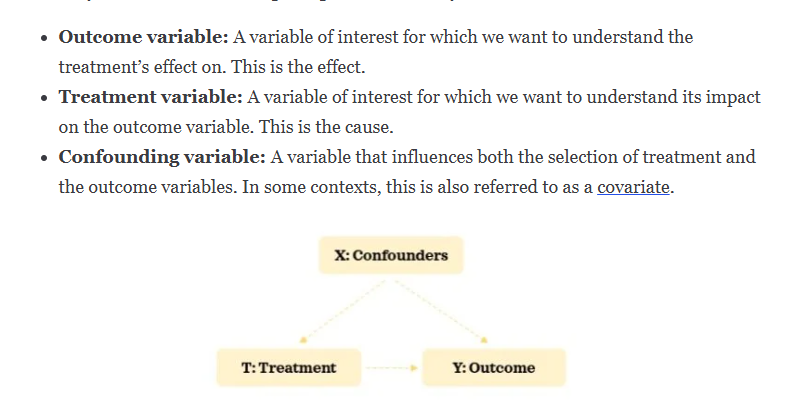

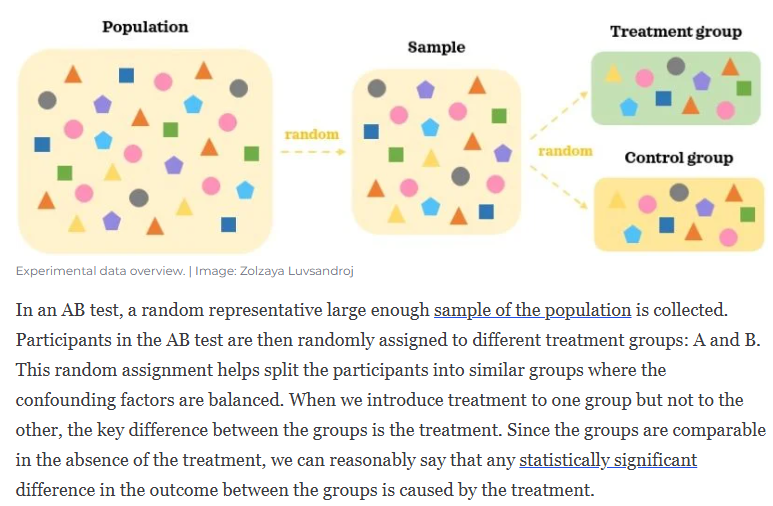
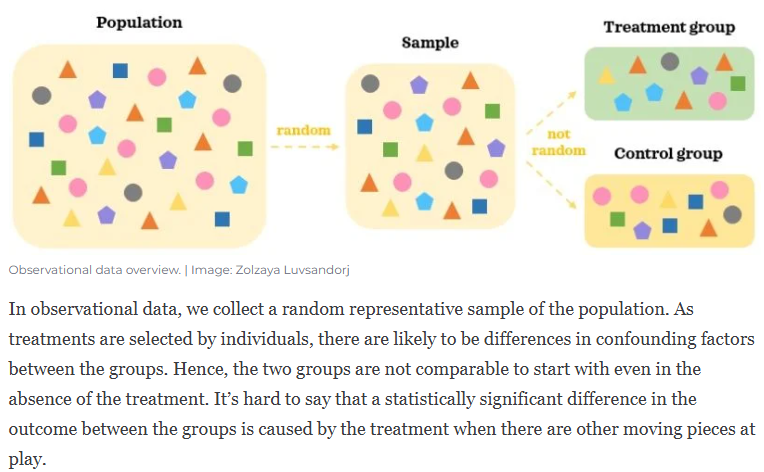

In [165]:
df = pd.read_csv('./data/titanic_train.csv').dropna(subset=['Age'])[['Survived', 'Pclass', 'Sex', 'Age']]

df['is_pclass3'] = df['Pclass']==3
df['is_female'] = df['Sex']=='female'
df['survived'] = df['Survived']
df['age'] = df['Age']

df = df.filter(['survived', 'is_pclass3', 'is_female', 'age']).dropna().reset_index(drop=True)

TREATMENT = 'is_pclass3'
OUTCOME = 'survived'

df = df[['survived', 'is_pclass3', 'is_female', 'age']]

display(df.shape)

- Passageiros da Classe Econômica 3 (Pclass = 3) tiveram uma taxa de sobrevivência menor do que os passageiros das classes 1 e 2 

In [166]:
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
True,355.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


- Passageiros da Classe Econômica 3 são majoritariamente mais novos que os das classes 1 e 2 

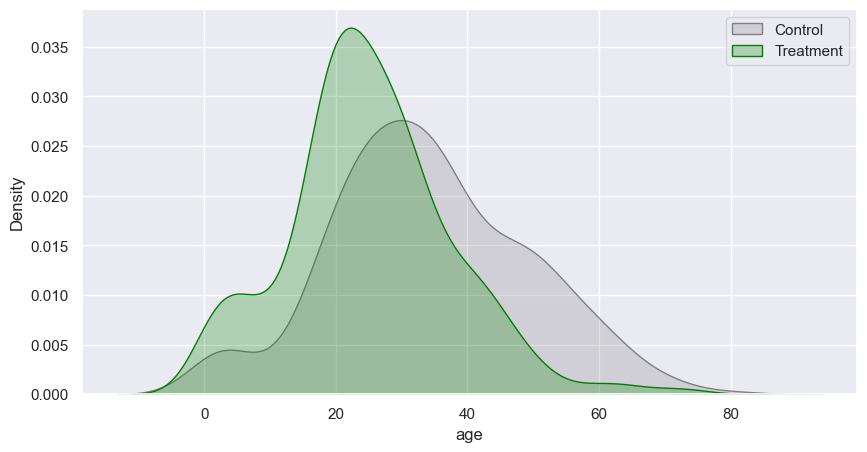

In [167]:
C_COLOR ='grey'
T_COLOR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'

sns.kdeplot(data = df.loc[df[TREATMENT] == 0], x = 'age', shade = True, color = C_COLOR, label = C_LABEL)
sns.kdeplot(data = df.loc[df[TREATMENT] == 1], x = 'age', shade = True, color = T_COLOR, label = T_LABEL)
plt.legend()
plt.show()

- Passageiros da Classe Econômica 3 (Pclass = 3) são majoritariamente do sexo masculino 

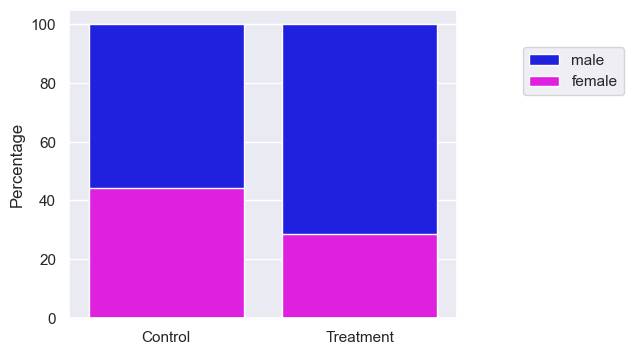

In [168]:
F_COLOR = 'magenta'
M_COLOR = 'blue'
F_LABEL = 'female'
M_LABEL = 'male'

df_crosstab_gender = 100*pd.crosstab(df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), df['is_female'].replace({True: F_LABEL, False: M_LABEL}), normalize = 'index')
df_crosstab_gender['All'] = 100

plt.figure(figsize=(5, 4))
sns.barplot(data=df_crosstab_gender, x=df_crosstab_gender.index.astype(str),  y="All", color=M_COLOR, label=M_LABEL)
sns.barplot(data=df_crosstab_gender, x=df_crosstab_gender.index.astype(str),  y='female', color=F_COLOR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage')
plt.show()

- Criou-se uma Regressão Logística para prever se o indivíduo é da Classe 3 com base na Idade e Gênero. Analisando os Escores de Propensão e o seu Logit, percebe-se que de fato há diferença entre os grupos de tratamento e controle, o que indica que a variável de tratamento não é aleatória.

In [169]:
# Build a descriptive model
print(f'Outcome --> {OUTCOME}')
print(f'Treatment --> {TREATMENT}')

t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df['propensity_bin'] = pd.qcut(df['proba'], 10, labels=False) + 1  # 1 a 10 (decis)
bin_counts = df.groupby(['propensity_bin', TREATMENT]).size().reset_index(name='count')

display(df.head())

Outcome --> survived
Treatment --> is_pclass3


,survived,is_pclass3,is_female,age,proba,logit,pred,propensity_bin
0,0,True,False,22.00,0.67,0.70,1,8
1,1,False,True,38.00,0.26,-1.02,0,2
2,1,True,True,26.00,0.40,-0.40,0,4
3,1,False,True,35.00,0.30,-0.87,0,2
4,0,True,False,35.00,0.51,0.03,1,5


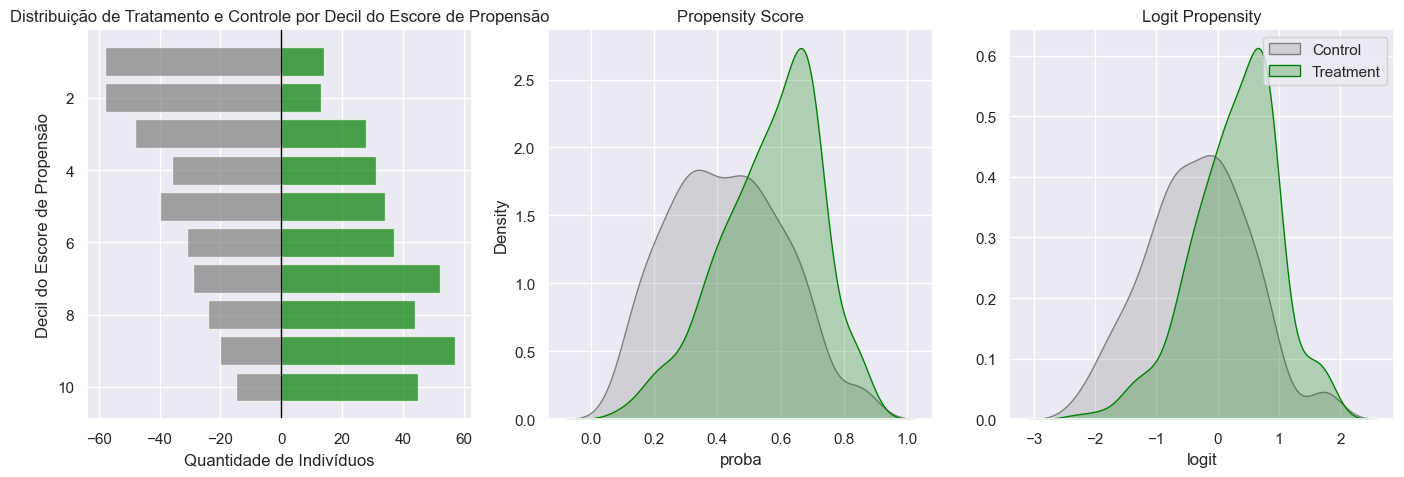

In [170]:
# Pivotar para gráfico
pivot_counts = bin_counts.pivot(index='propensity_bin', columns=TREATMENT, values='count').fillna(0)
pivot_counts = pivot_counts.rename(columns={0: C_LABEL, 1: T_LABEL})

# Tornar o controle negativo para espelhar no gráfico
pivot_counts[C_LABEL] = -pivot_counts[C_LABEL]

# Plotagem
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# --- Gráfico 1: tipo SHAP / espelho ---
ax[0].barh(pivot_counts.index, pivot_counts[C_LABEL], color=C_COLOR, alpha=0.7, label=C_LABEL)
ax[0].barh(pivot_counts.index, pivot_counts[T_LABEL], color=T_COLOR, alpha=0.7, label=T_LABEL)
ax[0].axvline(0, color='black', linewidth=1)
ax[0].set_title('Distribuição de Tratamento e Controle por Decil do Escore de Propensão')
ax[0].set_xlabel('Quantidade de Indivíduos')
ax[0].set_ylabel('Decil do Escore de Propensão')
#ax[0].legend(loc='upper right')
ax[0].invert_yaxis()  # Deixar o 1º decil no topo

# --- Gráfico 2: Propensity ---
sns.kdeplot(data=df.loc[df[TREATMENT]==0], x='proba', shade=True, color='grey', label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df.loc[df[TREATMENT]==1], x='proba', shade=True, color='green', label=T_LABEL, ax=ax[1])
ax[1].set_title('Propensity Score')
#ax[1].legend(loc='center', bbox_to_anchor=(1.1, -0.3))

# --- Gráfico 3: Logit Propensity ---
sns.kdeplot(data=df.loc[df[TREATMENT]==0], x='logit', shade=True, color='grey', label=C_LABEL, ax=ax[2])
sns.kdeplot(data=df.loc[df[TREATMENT]==1], x='logit', shade=True, color='green', label=T_LABEL, ax=ax[2])
ax[2].set_title('Logit Propensity')
ax[2].set_ylabel("")

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

- A ideia do pareamento é permitir que indivíduos com a mesma propensão a participarem do Tratamento sejam colocados lado-a-lado, mesmo que empiricamente uma parte não tenha sido submetida ao Tratamento. Esse mecanismo é importante para identificarmos pessoas parecidas em termos de covariáveis, mas que apenas uma parte foi submetida ao Tratamento e a outra ficou como controle. 

    - match → o índice do controle mais próximo para cada indivíduo tratado (baseado no logit da propensão).

    - distance → a diferença de logit entre o tratado e o controle selecionado.

    - A ideia é simples: para cada pessoa tratada, encontrar um controle “parecido”, em termos de escore de propensão (logit).

In [ ]:
# Loop para buscar o controle mais próximo de cada tratado
# Busca para Cima
    # Para cada linha do DataFrame (row) que representa um indivíduo tratado (is_pclass3 = True)
    # Filtra os registros com logit maior ou igual ao do tratado (acima)
    # Mantém apenas controles (~acima[TREATMENT])
    # Seleciona o primeiro controle acima (mais próximo em logit)
# Busca para Baixo
    # Filtra os registros com logit menor ou igual ao do tratado (abaixo)
    # Mantém apenas controles (~abaixo[TREATMENT])
    # Seleciona o último controle abaixo (mais próximo em logit)

# Escolhe o controle mais próximo
    # Compara qual controle (acima ou abaixo) tem menor distância absoluta em logit
    # melhor_match → registro do controle selecionado
    # melhor_dist → diferença de logit entre tratado e controle

df.sort_values('logit', inplace=True)
n = len(df) - 1  # índice do último registro

for i, (indice, linha) in enumerate(df.iterrows()): 
    # Somente para indivíduos tratados
    if linha[TREATMENT]:  
        
        # ---------- Busca para cima ----------
        # Considera todos os registros com logit >= do indivíduo tratado
        if i < n:  
            acima = df.iloc[i:]  
            # Mantém apenas os controles (não tratados)
            controles_acima = acima[~acima[TREATMENT]]  
            # Seleciona o primeiro controle acima
            match_acima = controles_acima.iloc[0]  
            # Calcula a diferença de logit
            distancia_acima = match_acima['logit'] - linha['logit']
            # Salva o índice do controle e a distância no DataFrame
            df.loc[indice, 'match'] = match_acima.name
            df.loc[indice, 'distance'] = distancia_acima
        
        # ---------- Busca para baixo ----------
        # Considera todos os registros com logit <= do indivíduo tratado
        if i > 0:  
            abaixo = df.iloc[:i-1]  
            # Mantém apenas os controles
            controles_abaixo = abaixo[~abaixo[TREATMENT]]  
            # Seleciona o último controle abaixo
            match_abaixo = controles_abaixo.iloc[-1]  
            # Calcula a diferença de logit
            distancia_abaixo = match_abaixo['logit'] - linha['logit']
            
            # ---------- Decide qual controle é mais próximo ----------
            # Caso seja o último registro, apenas salva o match abaixo
            if i == n:
                df.loc[indice, 'match'] = match_abaixo.name
                df.loc[indice, 'distance'] = distancia_abaixo
            # Caso contrário, sobrescreve se o controle abaixo estiver mais próximo
            elif distancia_abaixo < distancia_acima:
                df.loc[indice, 'match'] = match_abaixo.name
                df.loc[indice, 'distance'] = distancia_abaixo

# Exibe apenas os indivíduos tratados com seus matches
df[df[TREATMENT]]


,survived,is_pclass3,is_female,age,proba,logit,pred,propensity_bin,match,distance
385,1,True,True,63.00,0.09,-2.33,0,1,221.00,0.00
679,0,True,False,74.00,0.12,-2.01,0,1,10.00,-0.06
91,0,True,False,70.50,0.14,-1.82,0,1,74.00,-0.03
586,0,True,True,48.00,0.18,-1.55,0,1,689.00,0.00
225,0,True,False,65.00,0.18,-1.54,0,1,689.00,-0.01
...,...,...,...,...,...,...,...,...,...,...
15,0,True,False,2.00,0.85,1.75,1,10,154.00,-0.05
309,0,True,False,1.00,0.86,1.80,1,10,273.00,-0.05
132,0,True,False,1.00,0.86,1.80,1,10,146.00,0.00
628,1,True,False,1.00,0.86,1.80,1,10,146.00,0.00


In [172]:
indices = df[df['match'].notna()].index.append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,propensity_bin,match,distance
0,1,True,True,63.00,0.09,-2.33,0,1,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,1,10.00,-0.06
2,0,True,False,70.50,0.14,-1.82,0,1,74.00,-0.03
3,0,True,True,48.00,0.18,-1.55,0,1,689.00,0.00
4,0,True,False,65.00,0.18,-1.54,0,1,689.00,-0.01
...,...,...,...,...,...,...,...,...,...,...
705,1,False,False,3.00,0.84,1.69,1,10,NaN,NaN
706,1,False,False,2.00,0.85,1.75,1,10,NaN,NaN
707,1,False,False,1.00,0.86,1.80,1,10,NaN,NaN
708,1,False,False,1.00,0.86,1.80,1,10,NaN,NaN


In [173]:
COLUMNS = ['age', 'is_female', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT], COLUMNS+['match']], 
                   df[COLUMNS], left_on='match', 
                   right_index=True, 
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,10.00,58.00,True,1
91,70.50,False,0,74.00,71.00,False,0
586,48.00,True,0,689.00,48.00,True,1
225,65.00,False,0,689.00,48.00,True,1
...,...,...,...,...,...,...,...
15,2.00,False,0,154.00,3.00,False,1
309,1.00,False,0,273.00,2.00,False,1
132,1.00,False,0,146.00,1.00,False,1
628,1.00,False,1,146.00,1.00,False,1


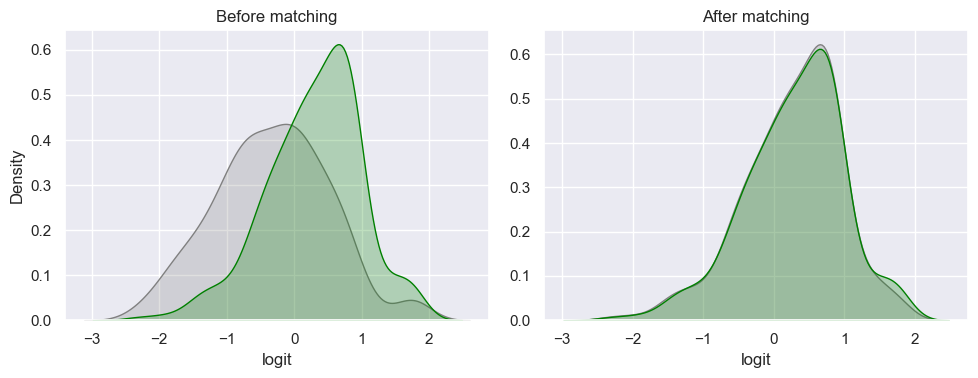

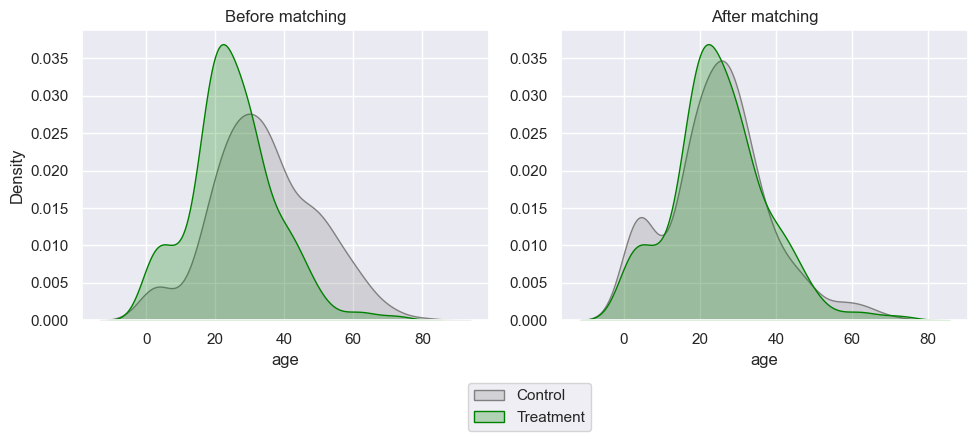

In [174]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, shade=True, 
                color=C_COLOR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, shade=True, 
                color=T_COLOR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                shade=True, color=C_COLOR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                shade=True, color=T_COLOR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
plt.show()

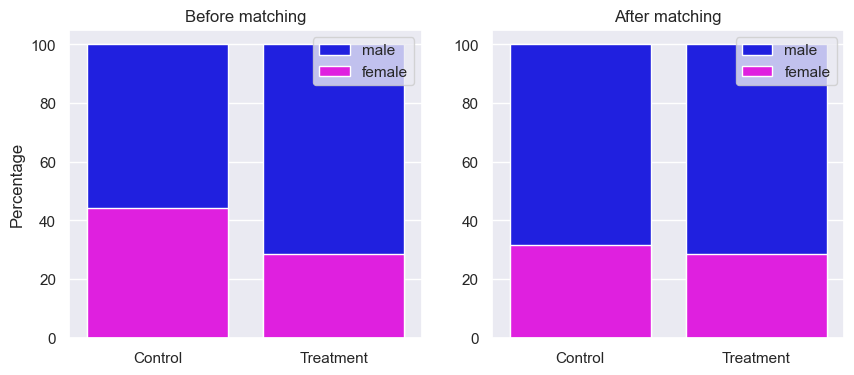

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=df_crosstab_gender, x=df_crosstab_gender.index.astype(str), y="All", 
            color=M_COLOR, label=M_LABEL, ax=ax[0])
sns.barplot(data=df_crosstab_gender, x=df_crosstab_gender.index.astype(str), y='Female', 
            color=F_COLOR, label=F_LABEL, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
df_crosstab_gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['is_female'].replace({True: 'Female', False: 'Male'}), 
    normalize='index'
)
df_crosstab_gender_after['All'] = 100
sns.barplot(data=df_crosstab_gender_after, x=df_crosstab_gender_after.index.astype(str), 
            y="All", color=M_COLOR, label=M_LABEL, ax=ax[1])
sns.barplot(data=df_crosstab_gender_after, x=df_crosstab_gender_after.index.astype(str), 
            y='Female', color=F_COLOR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('')
plt.show()

- Análise do Efeito Médio do Tratamento em Todo o Público, nos Tratados e nos Não Tratados 

    - Antes do Propensity Score Matching: Não há ajuste para viés de seleção. Se o grupo tratado for diferente do grupo controle em características relevantes (como idade ou gênero), essa diferença média pode não refletir o efeito causal real, apenas a diferença observada.

    - Depois do Propensity Score Matching: 

| Conceito | O que mede                   | Quem está incluído                                  |
| -------- | ---------------------------- | --------------------------------------------------- |
| **ATE**  | Efeito médio do tratamento   | Todos os indivíduos (tratados + não tratados)       |
| **ATT**  | Efeito médio do tratamento   | Apenas os indivíduos que receberam o tratamento     |
| **ATC**  | Efeito médio se não tratados | Apenas os indivíduos que não receberam o tratamento |



In [183]:
display(matched_df.head())
display(matches.head())

,survived,is_pclass3,is_female,age,proba,logit,pred,propensity_bin,match,distance
0,1,True,True,63.00,0.09,-2.33,0,1,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,1,10.00,-0.06
2,0,True,False,70.50,0.14,-1.82,0,1,74.00,-0.03
3,0,True,True,48.00,0.18,-1.55,0,1,689.00,0.00
4,0,True,False,65.00,0.18,-1.54,0,1,689.00,-0.01


,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,10.00,58.00,True,1
91,70.50,False,0,74.00,71.00,False,0
586,48.00,True,0,689.00,48.00,True,1
225,65.00,False,0,689.00,48.00,True,1


In [190]:
print('After Using Propensity Score Matching')
survived_t = np.mean(matches['survived_t'])
survived_c = np.mean(matches['survived_c'])
att = survived_t - survived_c
print('The Average Treatment Effect on Treated (ATT): {:.4f}'.format(att))

After Using Propensity Score Matching
The Average Treatment Effect on Treated (ATT): -0.2592


In [ ]:
y = df[OUTCOME].values
t = df[TREATMENT].values
X = df[['is_female', 'age']]
X = pd.DataFrame(StandardScaler().fit_transform(X), 
                 columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.259      0.046     -5.623      0.000     -0.350     -0.169
           ATC     -0.292      0.056     -5.240      0.000     -0.401     -0.183
           ATT     -0.227      0.052     -4.400      0.000     -0.328     -0.126



# <font color='orange' style='font-size: 40px;'> Exemplo Diferenças-em-Diferenças </font>
<hr style='border: 2px solid orange;'>

> O método de Diferenças-em-Diferenças compara a evolução de um desfecho ao longo do tempo entre grupos tratados e não tratados. A lógica é que, na ausência do tratamento, a trajetória dos dois grupos seria paralela, e portanto qualquer divergência observada após a intervenção pode ser atribuída ao efeito causal. Essa suposição de “tendências paralelas” é crucial, pois, se não for válida, a estimação estará enviesada. O DiD é muito usado em políticas públicas e avaliação de impacto, principalmente quando há dados longitudinais ou em painel.

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

https://www.youtube.com/watch?v=j37HHDypCp8&t=51s

https://anthonypuggs.substack.com/p/python-replication-of-card-and-krueger?utm_campaign=post&utm_medium=web

https://github.com/AnthonyPuggs/CardKrueger1994Replication/tree/main

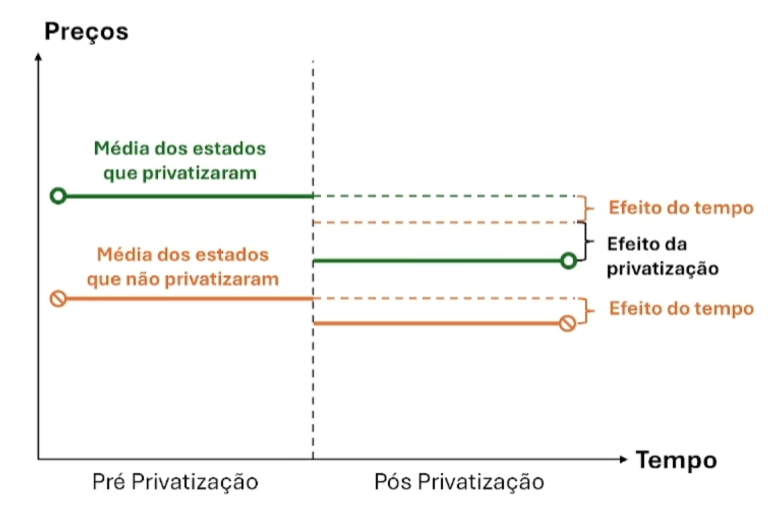
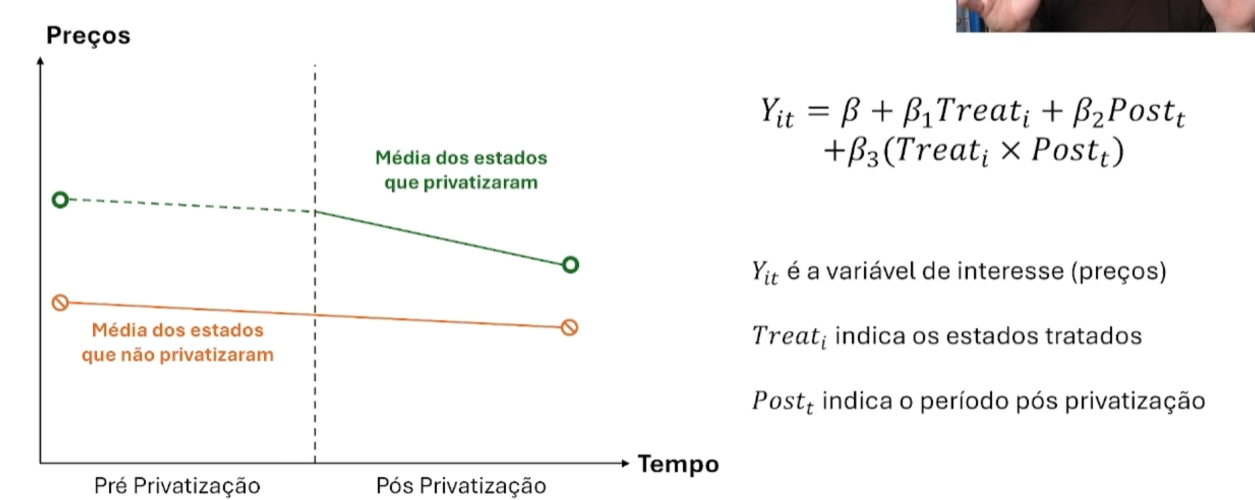
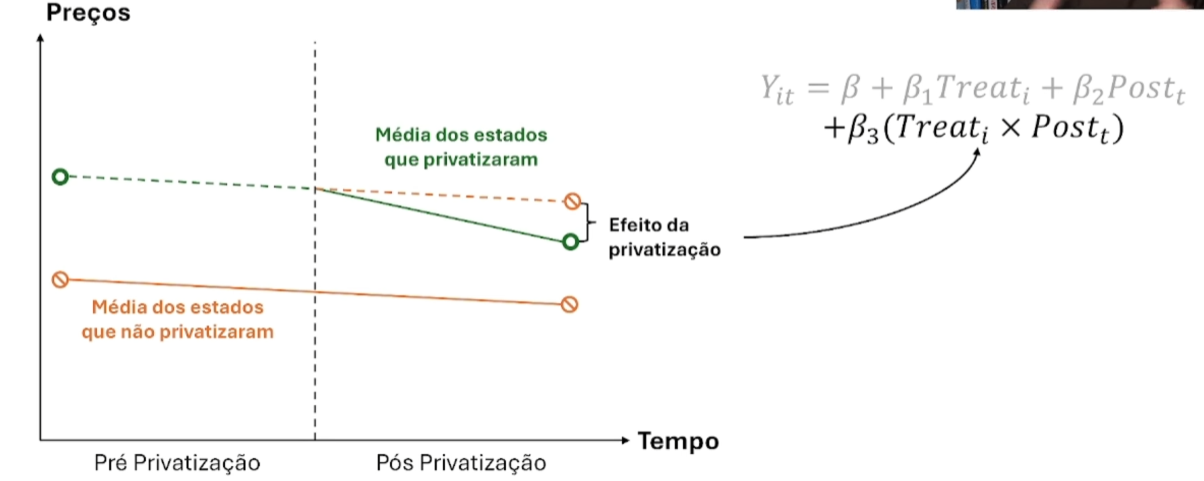

In [2]:
df = pd.read_stata("./data/dataset.dta")

In [3]:
df 

,st_abbrev,yq,spend_pc,quantity_pcp,presc_pc,priceperpresc,share_dual,price_gen,price_brandng,price_brandwg,genpen_presc,geneff_presc,genacc_presc,s_offset,s_MCO,wgt,genacc_sim,FX,F8,F7,F6,F5,F4,F3,F2,F1,L0,L1,L2,L3,L4,L5,L6,L7,L8,LX,treated,samePDL,switchers,sample1,exp,state_r,lnspend_pc,lnquantity_pcp,lnpresc_pc,lnpriceperpresc,notsamePDL,treatedXsamePDL,treatedXnotsamePDL,switchers_alt
0,AK,201,294.03,251.48,2.49,117.96,0.12,62.75,249.46,172.64,0.62,0.77,0.80,0.51,0.00,29493706.00,0.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,1,5.68,5.53,0.91,4.77,1,0.00,0.00,0
1,AK,202,330.90,237.89,2.47,133.97,0.12,61.33,325.64,192.62,0.64,0.79,0.80,0.51,0.00,29493706.00,0.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,1,5.80,5.47,0.90,4.90,1,0.00,0.00,0
2,AK,203,328.22,235.39,2.42,135.37,0.12,57.94,339.38,201.12,0.64,0.79,0.81,0.50,0.00,29493706.00,0.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,1,5.79,5.46,0.89,4.91,1,0.00,0.00,0
3,AK,204,400.43,242.35,2.54,157.64,0.12,68.05,427.01,216.93,0.65,0.80,0.81,0.50,0.00,29493706.00,0.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,1,5.99,5.49,0.93,5.06,1,0.00,0.00,0
4,AK,205,436.87,229.04,2.48,176.47,0.12,84.35,445.88,257.12,0.65,0.80,0.82,0.51,0.00,29493706.00,0.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,1,6.08,5.43,0.91,5.17,1,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,WY,222,144.13,145.64,1.98,72.66,0.16,18.51,431.80,174.53,0.76,0.82,0.93,0.36,0.00,7931513.00,0.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,51,4.97,4.98,0.68,4.29,1,0.00,0.00,0
1322,WY,223,151.32,147.29,2.06,73.29,0.16,18.02,474.59,170.72,0.77,0.83,0.93,0.37,0.00,7931513.00,0.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,51,5.02,4.99,0.72,4.29,1,0.00,0.00,0
1323,WY,224,155.91,154.73,2.25,69.23,0.17,18.91,499.98,133.64,0.78,0.84,0.93,0.31,0.00,7931513.00,0.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,51,5.05,5.04,0.81,4.24,1,0.00,0.00,0
1324,WY,225,155.70,161.78,2.22,70.08,0.17,17.60,477.11,122.18,0.76,0.82,0.92,0.33,0.00,7931513.00,0.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,1,0,51,5.05,5.09,0.80,4.25,1,0.00,0.00,0


# <font color='orange' style='font-size: 40px;'> Causal Forest </font>
<hr style='border: 2px solid orange;'>

> EconML é uma biblioteca de Inferência Causal desenvolvida pela Microsoft

https://www.pywhy.org/EconML/spec/overview.html

https://www.pywhy.org/EconML/spec/causal_intro.html

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

> 1. Qual o impacto de estar na terceira classe sobre a probabilidade de sobrevivência, mantendo idade e sexo constantes?

> 2. Para isso, isolou-se o efeito do tratamento controlando por covariáveis (idade e sexo):

- model_y: RandomForest para prever Y a partir de X.

- model_t: RandomForest para prever T a partir de X.

- CausalForestDML: combina os resíduos de Y e T para estimar o efeito causal condicional de T sobre Y, controlando X.

> 3. O fluxo seria:

- Prever Y_hat = f(X) → resíduos Y - Y_hat.

- Prever T_hat = g(X) → resíduos T - T_hat.

- Estimar CATE ajustando os resíduos: $\hat{Y} = \theta(X).\hat{T} + e. $

> 4. Interpretação:

| Observação   | `CATE` estimado                                             |
| ------------ | ----------------------------------------------------------- |
| Passageiro 1 | -0.20 → estar na 3ª classe reduz 20% a chance de sobreviver |
| Passageiro 2 | -0.15 → efeito similar para outro passageiro                |
| ...          | ...                                                         |


- Sinais negativos indicam efeito desfavorável do tratamento (is_pclass3 = 1).

- Magnitude indica o tamanho do impacto sobre a probabilidade de sobrevivência.

- Média (ATE) resume o efeito geral para todo o grupo da 3ª classe.



Exemplo de 10 efeitos causais estimados (CATE):
[-0.32697331 -0.24755413 -0.28418649 -0.24755413 -0.32697331 -0.24755413
 -0.32697331 -0.32697331 -0.26287067 -0.24755413]

ATE médio estimado: -0.282


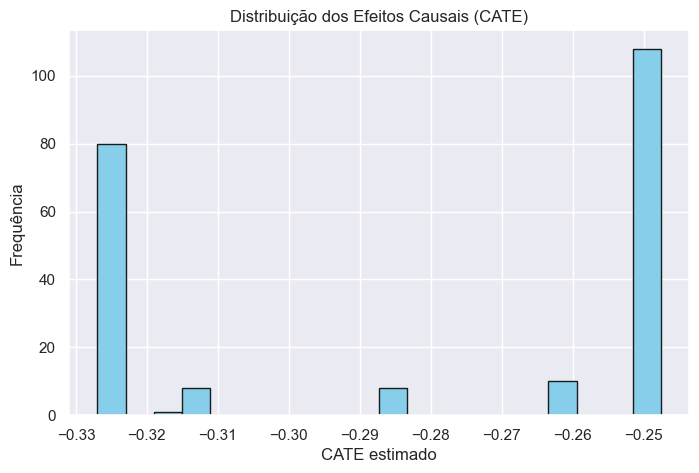

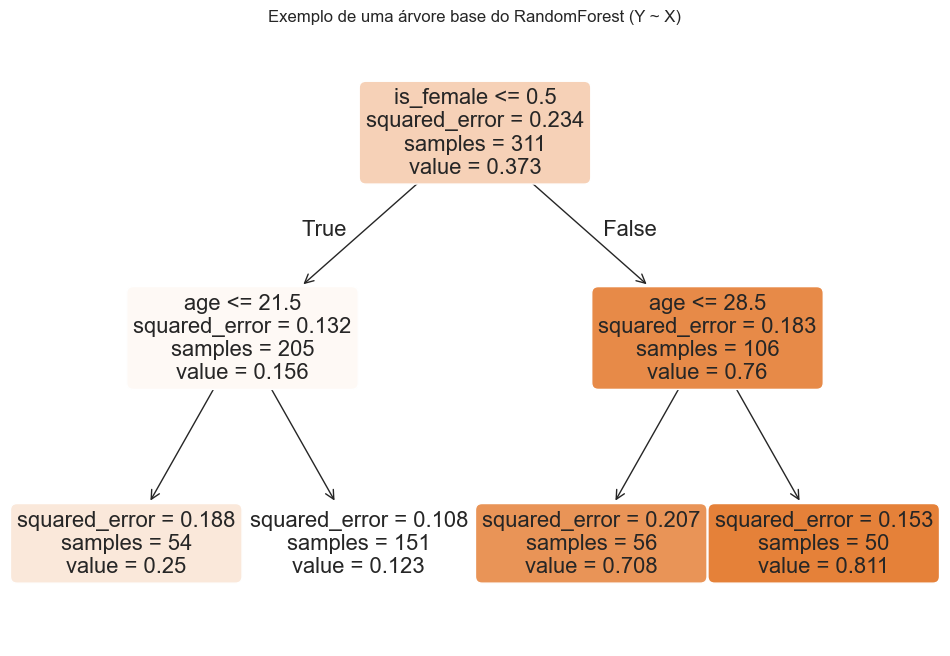

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
from sklearn import tree

# -------------------------------
# 1) Dataset Titanic
# -------------------------------
df = sns.load_dataset('titanic')
df = df[['survived', 'pclass', 'sex', 'age']].dropna()
df['is_pclass3'] = (df['pclass']==3).astype(int)
df['is_female'] = (df['sex']=='female').astype(int)

X = df[['is_female', 'age']]
T = df['is_pclass3'].astype(float)
Y = df['survived'].astype(float)

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)

# -------------------------------
# 2) CausalForestDML
# -------------------------------
model_y = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, max_depth = 2, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, max_depth = 2, random_state=42)

cf_dml = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    n_estimators=500,
    min_samples_leaf=50, 
    max_depth = 2,
    random_state=42
)

cf_dml.fit(Y_train, T_train, X=X_train)

# -------------------------------
# 3) Predizer CATE
# -------------------------------
cate_dml = cf_dml.effect(X_test)

print("Exemplo de 10 efeitos causais estimados (CATE):")
print(cate_dml[:10])
print(f"\nATE médio estimado: {cate_dml.mean():.3f}")

# -------------------------------
# 4) Plotar distribuição dos CATEs
# -------------------------------
plt.figure(figsize=(8,5))
plt.hist(cate_dml, bins=20, color='skyblue', edgecolor='k')
plt.title("Distribuição dos Efeitos Causais (CATE)")
plt.xlabel("CATE estimado")
plt.ylabel("Frequência")
plt.show()

# -------------------------------
# 5) Plotar uma árvore do modelo_y (RandomForest do estágio base)
# -------------------------------
# Treinar RandomForest separadamente apenas para visualização
rf_vis = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, max_depth = 2, random_state=42)
rf_vis.fit(X_train, Y_train)

plt.figure(figsize=(12,8))
tree.plot_tree(rf_vis.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.title("Exemplo de uma árvore base do RandomForest (Y ~ X)")
plt.show()
